### Dataset Preparation Notebook

Contains scripts for preprocessing Recipe Classifier and Recipe Cropper datasets in Databricks.

##### Dataset: Recipe Classifier
- Downloads images from S3 to DBFS
- Categorizes files based on keywords in `metadata.csv`
- Avoids downloading the same file twice

##### Dataset: Recipe Cropper
- Downloads images and masks from S3
- Avoids downloading the same file twice
- Downloads missing pairs of images/masks
- Filename normalization
- Augmentation scripts

In [0]:
!pip install -U -q torch torchvision ipywidgets opencv-python

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import boto3

s3 = boto3.client('s3')

BUCKET_NAME = '<AWS_BUCKET_NAME>'
BUCKET_PATH = 'recipecropper/dataset/mask/step/'

root_dir = "<PATH>"


In [0]:
# List files with pagination
files = []
continuation_token = None

while True:
    if continuation_token:
        response = s3.list_objects_v2(Bucket=BUCKET_NAME, 
                                    Prefix=BUCKET_PATH,
                                    ContinuationToken=continuation_token)
    else:
        response = s3.list_objects_v2(Bucket=BUCKET_NAME, 
                                    Prefix=BUCKET_PATH)

    files.extend([obj['Key'] for obj in response.get('Contents', [])])

    # Check for more files
    if response.get("IsTruncated"):
        continuation_token = response.get("NextContinuationToken")
    else:
        break

files = files[1:] # Remove the bucket name

print(len(files), "files listed.")

5047 files listed.


##### DATASET: Recipe Classifier

In [0]:
# DATASET: Recipe Classifier
# Download files + Categorize w/ metadata.csv

import pandas as pd
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm

CSV_METADATA = root_dir + "recipe_classifier/dataset/metadata.csv"
SAVE_DIR = root_dir + "recipe_classifier/dataset/dataset_20dec/"

dbutils.fs.mkdirs(SAVE_DIR)

retry = [] # Fail counter

# List existing files in dbfs to avoid downloading twice
files_dbfs = {file.name for file in dbutils.fs.ls(SAVE_DIR)}

files = [file for file in files if file.split("/")[-1] not in files]

# Sort out image by keyword
metadata = pd.read_csv(f"/dbfs{CSV_METADATA}")

def _normalize_keywords(keywords):
    if isinstance(keywords, np.ndarray):
        return keywords.tolist()
    elif isinstance(keywords, str):
        return keywords.strip("[]").replace("'", "").replace('"', "").split()
    return keywords

metadata["Keywords"] = metadata["Keywords"].apply(_normalize_keywords)

# Keywords and mappings
relevant_keywords = [
    "pan",
    "oven-dish",
    "grill-plate",
    "oven-tray",
    "chopping-board",
    "medium", # chopping-board + medium
    "CP", # chopping-board + CP
    "grill-tray",
    "pot-two-handles-medium",
    "pot-two-handles-small",
    "pot-two-handles-shallow",
    "pot-one-handle",
    "sauce-pan",
    "saucepan",
    "glass-bowl-large",
    "glass-bowl-medium",
    "glass-bowl-small",
    "finalstep",
    "group_step",
]

keyword_mapping = {
    "sauce-pan": "saucepan",
}

# Download from S3 to DBFS
for file in tqdm(files, desc="Processing files", unit="file"):
    file_name = file.split("/")[-1]
    file_metadata = metadata[metadata["FileName"] == file_name]
    if file_metadata.empty:
        print(f"[Warning] No metadata found for {file_name}. Skipping.")

    # Determine category based on keywords
    keywords = file_metadata["Keywords"].iloc[0]
    category = None

    # Special case for "chopping-board"
    if "chopping-board" in keywords:
        if "medium" in keywords:
            category = "medium"
        elif "CP" in keywords:
            category = "CP"
        else:
            category = "chopping-board"
    
    # All other cases
    else:
        for keyword in keywords:
            if keyword in relevant_keywords:
                category = keyword_mapping.get(keyword, keyword)
                break

    if not category:
        print(f"[Warning] No relevant category found for: {file_name}. Skipping.")
        continue

    # Craete dbfs path based on category
    category_path = f"{SAVE_DIR}{category}/"
    dbutils.fs.mkdirs(f"dbfs:{category_path}")
    dbfs_path = "/dbfs" + category_path + file_name

    try:
        # Download from S3
        s3_obj = s3.get_object(Bucket=BUCKET_NAME, Key=file)
        file_content = s3_obj["Body"].read() # Read content into memory

        # Write to DBFS
        with open(f"{dbfs_path}", "wb") as f:
            f.write(file_content)
        print(f"[Success] Saved {Path(file).name} under {'/'.join(dbfs_path.split('/')[5:])}")

    except Exception as e:
        print(f"[Error] Failed to download {file}: {e}")
        retry.append(file)

if retry:
    print(f"\nError downloading {len(retry)} files: {retry}")

print(f"\n[DONE] Successfuly downloaded {len(files) - len(retry)} files.")


Processing files:   0%|          | 0/5042 [00:00<?, ?file/s]

[Success] Saved EP_Y24_R01_W49_AUS_02_ 1_original.jpg under recipe_classifier/dataset/dataset_20dec/pot-two-handles-medium/EP_Y24_R01_W49_AUS_02_ 1_original.jpg
[Success] Saved EP_Y24_R01_W49_AUS_02__original.jpg under recipe_classifier/dataset/dataset_20dec/group_step/EP_Y24_R01_W49_AUS_02__original.jpg
[Success] Saved EP_Y24_R01_W49_AUS_03__original.jpg under recipe_classifier/dataset/dataset_20dec/pan/EP_Y24_R01_W49_AUS_03__original.jpg
[Success] Saved EP_Y24_R01_W49_AUS_04__original.jpg under recipe_classifier/dataset/dataset_20dec/finalstep/EP_Y24_R01_W49_AUS_04__original.jpg
[Success] Saved EP_Y24_R01_W52_AUS_04__original.jpg under recipe_classifier/dataset/dataset_20dec/finalstep/EP_Y24_R01_W52_AUS_04__original.jpg
[Success] Saved EP_Y24_R04_W51_AUS_01__original.jpg under recipe_classifier/dataset/dataset_20dec/group_step/EP_Y24_R04_W51_AUS_01__original.jpg
[Success] Saved EP_Y24_R04_W51_AUS_03__original.jpg under recipe_classifier/dataset/dataset_20dec/glass-bowl-large/EP_Y24_R

In [0]:
print(SAVE_DIR)
dbutils.fs.rm(f"dbfs:{SAVE_DIR}", recurse=True)

<PATH>/recipe_classifier/dataset/dataset_1dec/


False

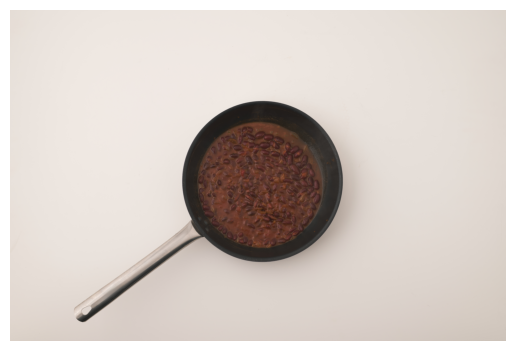

In [0]:
import matplotlib.pyplot as plt
from PIL import Image

IMAGE_PATH = "<PATH>/recipe_classifier/dataset/dataset_1dec/pan/EP_Y24_R09_W51_AUS_02__original.jpg"

img = Image.open(IMAGE_PATH)
plt.imshow(img)
plt.axis("off")
plt.show()

##### DATASET: Recipe Classifier

In [0]:
# DATASET: Recipe Cropper
# Download files

import pandas as pd
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm

SAVE_DIR = root_dir + "recipe_cropper/dataset/step/dataset_20dec/"
IMG_DIR = SAVE_DIR + "images/"
ANNO_DIR = SAVE_DIR + "annotations/"

# Downloading images or annotations?
# False: Download files to SAVE_DIR/images
# True: Download files to SAVE_DIR/annotations
ANNO = True

dbutils.fs.mkdirs(SAVE_DIR)
dbutils.fs.mkdirs(IMG_DIR)
dbutils.fs.mkdirs(ANNO_DIR)

retry = [] # Fail counter

# List existing files in dbfs to avoid downloading twice
target_dir = ANNO_DIR if ANNO else IMG_DIR
files_dbfs = {file.name for file in dbutils.fs.ls(target_dir)}

files = [file for file in files if file.split("/")[-1] not in files_dbfs]

# Download from S3 to DBFS
for file in tqdm(files, desc="Processing files", unit="file"):
    file_name = file.split("/")[-1]

    if ANNO == False: # Save to DBFS/images
        dbfs_path = "/dbfs" + IMG_DIR + file_name
    else: # Save to DBFS/annotations
        dbfs_path = "/dbfs" + ANNO_DIR + file_name

    try:
        # Download from S3
        s3_obj = s3.get_object(Bucket=BUCKET_NAME, Key=file)
        file_content = s3_obj["Body"].read() # Read content into memory

        # Write to DBFS
        with open(f"{dbfs_path}", "wb") as f:
            f.write(file_content)
        print(f"[Success] Saved {Path(file).name} under {'/'.join(dbfs_path.split('/')[5:])}")

    except Exception as e:
        print(f"[Error] Failed to download {file}: {e}")
        retry.append(file)

if retry:
    print(f"\nError downloading {len(retry)} files: {retry}")

print(f"\n[DONE] Successfuly downloaded {len(files) - len(retry)} files.")


Processing files:   0%|          | 0/5047 [00:00<?, ?file/s]

[Success] Saved EP_Y24_R01_W49_AUS_02_ 1_mask.jpg under recipe_cropper/dataset/step/dataset_20dec/annotations/EP_Y24_R01_W49_AUS_02_ 1_mask.jpg
[Success] Saved EP_Y24_R01_W49_AUS_02__mask.jpg under recipe_cropper/dataset/step/dataset_20dec/annotations/EP_Y24_R01_W49_AUS_02__mask.jpg
[Success] Saved EP_Y24_R01_W49_AUS_03__mask.jpg under recipe_cropper/dataset/step/dataset_20dec/annotations/EP_Y24_R01_W49_AUS_03__mask.jpg
[Success] Saved EP_Y24_R01_W49_AUS_04__mask.jpg under recipe_cropper/dataset/step/dataset_20dec/annotations/EP_Y24_R01_W49_AUS_04__mask.jpg
[Success] Saved EP_Y24_R01_W52_AUS_04__mask.jpg under recipe_cropper/dataset/step/dataset_20dec/annotations/EP_Y24_R01_W52_AUS_04__mask.jpg
[Success] Saved EP_Y24_R04_W51_AUS_01__mask.jpg under recipe_cropper/dataset/step/dataset_20dec/annotations/EP_Y24_R04_W51_AUS_01__mask.jpg
[Success] Saved EP_Y24_R04_W51_AUS_03__mask.jpg under recipe_cropper/dataset/step/dataset_20dec/annotations/EP_Y24_R04_W51_AUS_03__mask.jpg
[Success] Saved 

In [0]:
SAVE_DIR = root_dir + "recipe_cropper/dataset_tiny/"
IMG_DIR = SAVE_DIR + "images/"
ANNO_DIR = SAVE_DIR + "annotations/"

In [0]:
# DATASET: Recipe Cropper
# Fix file names to avoid removing good files

# Get list of files in both directories
img_files = {file.name for file in dbutils.fs.ls(IMG_DIR)}
anno_files = {file.name for file in dbutils.fs.ls(ANNO_DIR)}

def standardize_name(filename, file_type='original'):
    # Remove asterisks and fix spaces
    name = filename.replace('*', '').replace(' ', '')
    
    # Remove any existing _original or _mask suffix with varying underscores
    base = name.split('_original')[0].split('_mask')[0]
    
    # Remove any trailing underscores
    base = base.rstrip('_')
    
    # Add proper suffix
    return f"{base}__{file_type}.jpg"

# Process images
renamed_imgs = 0
for old_name in img_files:
    new_name = standardize_name(old_name, 'original')
    if old_name != new_name:
        print(f"Renaming image: {old_name} -> {new_name}")
        dbutils.fs.mv(IMG_DIR + old_name, IMG_DIR + new_name)
        renamed_imgs += 1

# Process annotations
renamed_annos = 0
for old_name in anno_files:
    new_name = standardize_name(old_name, 'mask')
    if old_name != new_name:
        print(f"Renaming annotation: {old_name} -> {new_name}")
        dbutils.fs.mv(ANNO_DIR + old_name, ANNO_DIR + new_name)
        renamed_annos += 1

print(f"\nRenamed {renamed_imgs} images and {renamed_annos} annotations to follow the convention")

# Now check for pairs again
img_files = {file.name for file in dbutils.fs.ls(IMG_DIR)}
anno_files = {file.name for file in dbutils.fs.ls(ANNO_DIR)}

def get_base_name(filename):
    return filename.replace('__original.jpg', '').replace('__mask.jpg', '')

# Create dictionaries with base_name as key
img_dict = {get_base_name(f): f for f in img_files}
anno_dict = {get_base_name(f): f for f in anno_files}

# Find unpaired files
unpaired_img = {f for base, f in img_dict.items() if base not in anno_dict}
unpaired_anno = {f for base, f in anno_dict.items() if base not in img_dict}

print(f"\nAfter renaming:")
print(f"Found {len(unpaired_img)} images without annotations")
print(f"Found {len(unpaired_anno)} annotations without images")

In [0]:
# DATASET: Recipe Cropper
# Remove files without a corresponding pair

# Get list of files in both directories
img_files = {file.name for file in dbutils.fs.ls(IMG_DIR)}
anno_files = {file.name for file in dbutils.fs.ls(ANNO_DIR)}

# Create mapping between original and mask files
def get_base_name(filename):
    return filename.replace('__original.jpg', '').replace('__mask.jpg', '')

# Create dictionaries with base_name as key
img_dict = {get_base_name(f): f for f in img_files}
anno_dict = {get_base_name(f): f for f in anno_files}

# Find unpaired files
unpaired_img = {f for base, f in img_dict.items() if base not in anno_dict}
unpaired_anno = {f for base, f in anno_dict.items() if base not in img_dict}

# Print summary
print(f"Found {len(unpaired_img)} images without annotations:")
for f in unpaired_img:
    print(f"  {f}")

print(f"\nFound {len(unpaired_anno)} annotations without images:")
for f in unpaired_anno:
    print(f"  {f}")

# Remove unpaired files
if unpaired_img or unpaired_anno:
    response = input("\nDo you want to remove these unpaired files? (yes/no): ")
    
    if response.lower() == 'yes':
        # Remove unpaired images
        for f in unpaired_img:
            dbutils.fs.rm(IMG_DIR + f)
        
        # Remove unpaired annotations
        for f in unpaired_anno:
            dbutils.fs.rm(ANNO_DIR + f)
            
        print(f"\nRemoved {len(unpaired_img)} images and {len(unpaired_anno)} annotations")
    else:
        print("\nNo files were removed")
else:
    print("\nAll files are properly paired!")

Found 1 images without annotations:
  HF_Y24_RA_R04_BW48_SE_AO34859_1_01__original-1.jpg

Found 0 annotations without images:



Do you want to remove these unpaired files? (yes/no):  yes


Removed 1 images and 0 annotations


In [0]:
SAVE_DIR = root_dir + "recipe_cropper/dataset/step/dataset_20dec_augmented_02/"
IMG_DIR = SAVE_DIR + "images/"
ANNO_DIR = SAVE_DIR + "annotations/"

# Count files in both directories
img_files = {file.name for file in dbutils.fs.ls(IMG_DIR)}
anno_files = {file.name for file in dbutils.fs.ls(ANNO_DIR)}

print(f"Number of files in images directory: {len(img_files)}")
print(f"Number of files in annotations directory: {len(anno_files)}")

In [0]:
# DATASET: Recipe Cropper
# Augmentation

import torch
import torchvision.transforms as T
from PIL import Image
import random
from typing import Tuple
from pathlib import Path
from tqdm.notebook import tqdm

def augment(image: Image.Image, mask: Image.Image, seed: int) -> Tuple[Image.Image, Image.Image]:
    """
    Applies data augmentation to an image and its mask.

    Performs the following augmentations in sequence:
        1. Color jitter (image only): Randomly changes brightness, contrast, saturation, and hue.
        2. Random affine transformation: Applies random rotation, translation, scaling, and shearing.
        3. Horizontal flip: Randomly flips the image and mask horizontally.
        4. Vertical flip: Randomfly flips the image and mask vertically.

    Args:
        - image: The input image to be augmented.
        - mask: The corresponding segmentation mask of the input image.
        - seed: Random seed for reproducibility.

    Returns:
        Tuple with the the augmented (image, mask) pair.
    """
    torch.manual_seed(seed)

    # ColorJitter
    color_jitter = T.ColorJitter(
        brightness=0.5,
        contrast=0.5,
        saturation=0.5,
        hue=0.2
    )
    image = color_jitter(image)

    # RandomAffine
    affine = T.RandomAffine(
        degrees=30,
        translate=(0.1, 0.1),
        scale=(0.8, 1.2),
        shear=10
    ) # Set affine params once and apply to both image and mask
    params = affine.get_params(affine.degrees, affine.translate, affine.scale, affine.shear, image.size)
    image = T.functional.affine(image, *params)
    mask = T.functional.affine(mask, *params)

    # Horizontal Flip
    if random.random() > 0.5:
        image = T.functional.hflip(image)
        mask = T.functional.hflip(mask)

    # Vertical Flip
    if random.random() > 0.5:
        image = T.functional.vflip(image)
        mask = T.functional.vflip(mask)

    return image, mask

# Source and destination dirs
SRC_DIR = root_dir + "recipe_cropper/dataset/step/dataset_20dec/"
DEST_DIR = root_dir + "recipe_cropper/dataset/step/dataset_20dec/"

src_img_dir = SRC_DIR + "images/"
src_anno_dir = SRC_DIR + "annotations/"
dest_img_dir = DEST_DIR + "images/"
dest_anno_dir = DEST_DIR + "annotations/"

dbutils.fs.mkdirs(DEST_DIR)
dbutils.fs.mkdirs(dest_img_dir)
dbutils.fs.mkdirs(dest_anno_dir)

def augment_and_save(img_path: str, mask_path: str, num_augmentations: int):
    img = Image.open(img_path)
    mask = Image.open(mask_path)
    
    for i in range(num_augmentations):
        aug_img, aug_mask = augment(img, mask, seed=i)
        
        # Create augmented filenames
        img_name = Path(img_path).name
        mask_name = Path(mask_path).name
        aug_img_name = f"aug_{str(i+1).zfill(2)}_{img_name}"
        aug_mask_name = f"aug_{str(i+1).zfill(2)}_{mask_name}"
        
        # Save augmented files
        aug_img.save(f"/dbfs{dest_img_dir}{aug_img_name}")
        aug_mask.save(f"/dbfs{dest_anno_dir}{aug_mask_name}")

# Process all files
img_files = [f"/dbfs{src_img_dir}{f.name}" for f in dbutils.fs.ls(src_img_dir)]
mask_files = [f"/dbfs{src_anno_dir}{f.name}" for f in dbutils.fs.ls(src_anno_dir)]

print("Number of images:", len(img_files))
print("Number of masks:", len(mask_files))

Number of images: 5042
Number of masks: 5042


In [0]:
# DATASET: Recipe Cropper
# Augmentation

# Set number of augmentations per image
NUM_AUGMENTATIONS = 2

for img_path, mask_path in tqdm(zip(img_files, mask_files), total=len(img_files)):
    try:
        augment_and_save(img_path, mask_path, NUM_AUGMENTATIONS)
    except Exception as e:
        print(f"Error processing {Path(img_path).name}: {e}")

  0%|          | 0/5042 [00:00<?, ?it/s]

In [0]:
RM_DIR = root_dir + "recipe_cropper/dataset/dataset_20dec_small"
dbutils.fs.rm(f"dbfs:{RM_DIR}", recurse=True)

True

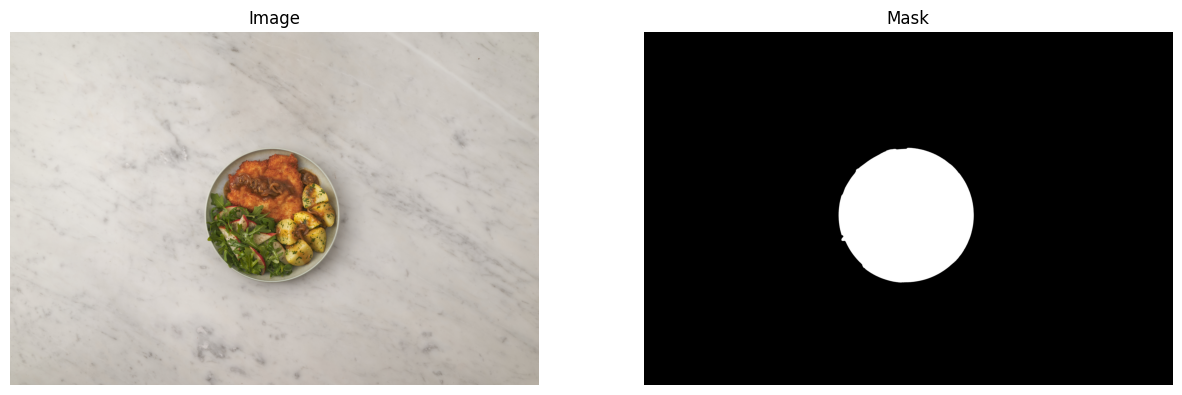

Showing: HF_Y24_R02_BW42_SE_C12343827-6_06__original.jpg


In [0]:
# DATASET: Recipe Cropper
# Display random image/annotation

import random
from PIL import Image
import matplotlib.pyplot as plt

# Get lists of files
img_files = [f"/dbfs{dest_img_dir}{f.name}" for f in dbutils.fs.ls(dest_img_dir)]
mask_files = [f"/dbfs{dest_anno_dir}{f.name}" for f in dbutils.fs.ls(dest_anno_dir)]

# Select random index
idx = random.randint(0, len(img_files)-1)

# Open image and mask
img = Image.open(img_files[idx])
mask = Image.open(mask_files[idx])

# Display side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
ax1.imshow(img)
ax1.set_title('Image')
ax1.axis('off')

ax2.imshow(mask)
ax2.set_title('Mask')
ax2.axis('off')

plt.show()

print(f"Showing: {Path(img_files[idx]).name}")

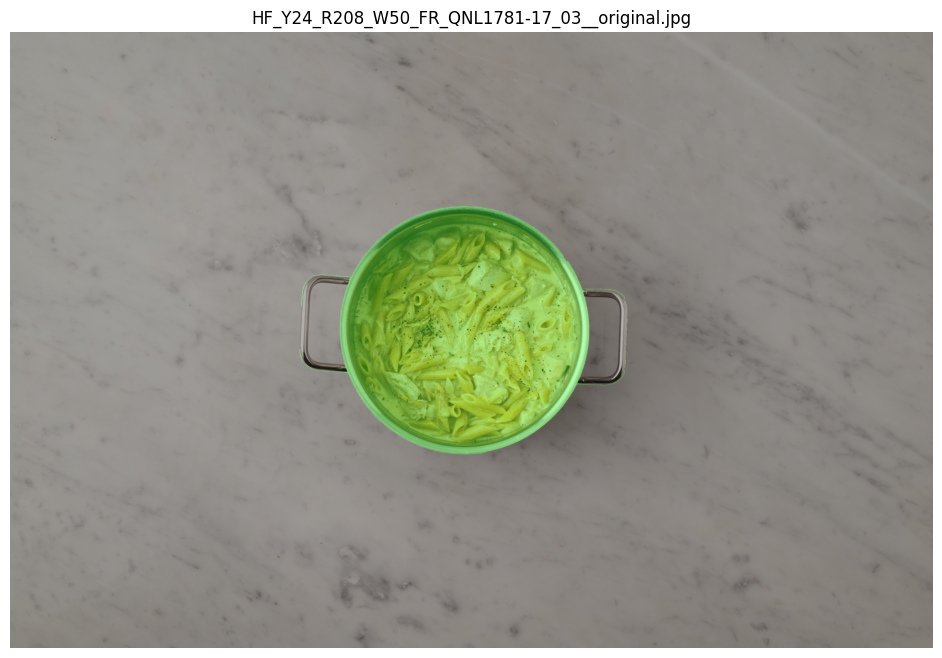

In [0]:
import numpy as np

def overlay_mask(image: Image.Image, mask: Image.Image) -> np.ndarray:
   img_array = np.array(image)
   mask_array = np.array(mask)[:,:,0]  # Take single channel from mask
   
   color_mask = np.zeros_like(img_array)
   color_mask[mask_array > 0] = [0, 255, 0]
   
   blended = img_array * 0.7 + color_mask * 0.3
   return blended.astype(np.uint8)

idx = random.randint(0, len(img_files)-1)
img = Image.open(img_files[idx])
mask = Image.open(mask_files[idx])

plt.figure(figsize=(12,8))
plt.imshow(overlay_mask(img, mask))
plt.axis('off')
plt.title(Path(img_files[idx]).name)
plt.show()

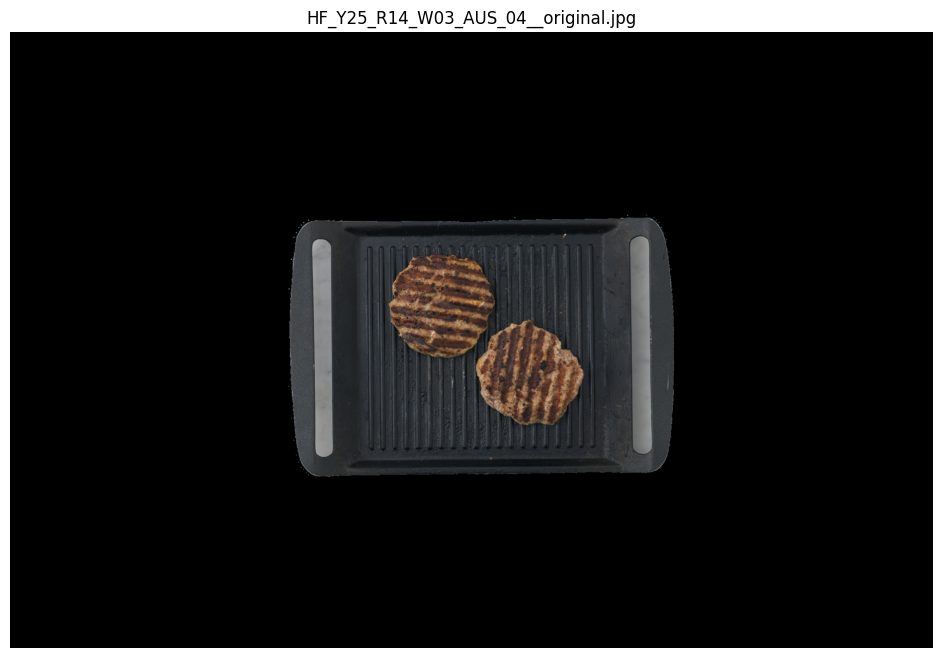

In [0]:
import numpy as np
import cv2

def crop(image: Image.Image, mask: Image.Image) -> np.ndarray:
   img_array = np.array(image)
   mask_array = np.array(mask)[:,:,0]  # Take single channel from mask
   
   return cv2.bitwise_and(img_array, img_array, mask=mask_array)

idx = random.randint(0, len(img_files)-1)
img = Image.open(img_files[idx])
mask = Image.open(mask_files[idx])

plt.figure(figsize=(12,8))
plt.imshow(crop(img, mask))
plt.axis('off')
plt.title(Path(img_files[idx]).name)
plt.show()

In [0]:
# Display random image with keyword
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import random

def crop(image: Image.Image, mask: Image.Image) -> np.ndarray:
    # Create a white background
    img_array = np.array(image)
    mask_array = np.array(mask)[:,:,0]  # Take single channel from mask
    
    # Create white background of same size as image
    white_background = np.ones_like(img_array) * 255
    
    # Blend the image with white background using the mask
    result = np.where(mask_array[:, :, np.newaxis] > 0, img_array, white_background)
    
    return result

def _normalize_keywords(keywords):
    if isinstance(keywords, np.ndarray):
        return keywords.tolist()
    elif isinstance(keywords, str):
        return keywords.strip("[]").replace("'", "").replace('"', "").split()
    return keywords

def display_image_with_keyword(img: Image.Image, mask: Image.Image, metadata_csv: str):
    # Read metadata
    metadata = pd.read_csv(metadata_csv)
    metadata["Keywords"] = metadata["Keywords"].apply(_normalize_keywords)
    
    # Get filename and find corresponding keywords
    filename = Path(img.filename).name
    file_metadata = metadata[metadata["FileName"] == filename]
    
    # Get keywords if available
    keywords = "No keywords found"
    if not file_metadata.empty:
        keywords = ", ".join(file_metadata["Keywords"].iloc[0])
    
    # Crop image
    cropped_img = crop(img, mask)
    
    # Set figure background to white
    plt.figure(figsize=(12,8), facecolor='white')
    plt.imshow(cropped_img)
    plt.axis('off')
    plt.title(f"File: {filename}\nKeywords: {keywords}")
    plt.show()

    print(filename)

CSV_METADATA = root_dir + "recipe_classifier/dataset/metadata.csv"
idx = random.randint(0, len(img_files)-1)
img = Image.open(img_files[idx])
mask = Image.open(mask_files[idx])

display_image_with_keyword(img, mask, f"/dbfs{CSV_METADATA}")

In [0]:
# Count files in dir
DIR = root_dir + "recipe_cropper/dataset/dataset_20dec_augmented_02/annotations/"

num_files = len([item for item in dbutils.fs.ls(DIR) if not item.isDir()])

print(f"Number of files in {DIR}: {num_files}")

In [0]:
from tqdm import tqdm

# Copy files between directories
SRC_DIR = root_dir + "recipe_cropper/dataset/step/dataset_20dec/images/"
DEST_DIR = root_dir + "recipe_cropper/dataset/step/dataset_20dec_augmented_02/images/"

# Get list of files in source dir
files = [file for file in dbutils.fs.ls(SRC_DIR) if not file.isDir()] # Filter files only

# Iterate through files and copy to destination dir
for file in tqdm(files, unit="file"):
    source_file = file.path
    destination_file = DEST_DIR + file.name
    dbutils.fs.cp(source_file, destination_file)

print(f"All files from {SRC_DIR} have been copied to {DEST_DIR}")

  9%|▉

*** WARNING: max output size exceeded, skipping output. ***

100%|██████████| 5042/5042 [52:34<00:00,  1.60file/s]

All files from <PATH>/recipe_cropper/dataset/step/dataset_20dec/images/ have been copied to <PATH>/recipe_cropper/dataset/step/dataset_20dec_augmented_02/images/


In [0]:
from random import sample
from tqdm import tqdm

def create_subset(src_dir, dest_dir, n_per_class):
    """
    Creates a subset of files from each class folder in a dataset directory.

    Args:
        src_dir (str): Path to the source dataset directory (e.g., "dbfs:/dataset/").
        dest_dir (str): Path to the destination directory (e.g., "dbfs:/dataset_small/").
        n_per_class (int): Number of files to copy from each class folder.
    """
    # List all class directories in the source directory
    class_dirs = [item.path for item in dbutils.fs.ls(src_dir) if item.isDir()]

    for class_dir in tqdm(class_dirs, desc="Processing classes", unit="class"):
        # Get the list of files in the class directory
        files = [item for item in dbutils.fs.ls(class_dir) if not item.isDir()]
        
        # If the class has fewer files than N, use all files
        num_files = min(len(files), n_per_class)
        
        # Randomly sample N files from the list
        sampled_files = sample(files, num_files)

        # Create corresponding directory in the destination path
        class_name = class_dir.rstrip("/").split("/")[-1]
        dest_class_dir = f"{dest_dir}/{class_name}/"
        dbutils.fs.mkdirs(dest_class_dir)

        # Copy the sampled files to the destination
        for file in sampled_files:
            source_file = file.path
            destination_file = f"{dest_class_dir}{file.name}"
            dbutils.fs.cp(source_file, destination_file)

    print(f"Subset dataset created at {dest_dir}")

SRC_DIR = root_dir + "recipe_classifier/dataset/dataset_20dec/"
DEST_DIR = root_dir + "recipe_classifier/dataset/dataset_20dec_small/"
create_subset(SRC_DIR, DEST_DIR, 30)

Processing classes: 100%|██████████| 17/17 [06:21<00:00, 22.43s/class]

Subset dataset created at <PATH>/recipe_classifier/dataset/dataset_20dec_small/
